In [6]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from monai.data import ImageDataset
from monai.transforms import Resize, EnsureChannelFirst, Compose, ScaleIntensity
from monai.metrics import DiceMetric
from torch.utils.data import DataLoader

from evaluate_util import get_model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
exp_name = "2024_03_12__08_58_04"
exp_path = "experiments/" + exp_name + "/"
with open(exp_path + "config.json", 'r') as file:
    config = json.load(file)

model_config = config["model_config"]

transformer = Compose([EnsureChannelFirst(),
                       ScaleIntensity(),
                       Resize(config["image_size"])])

val_image_path = "data/REFUGE2/Validation/Images/"
val_dm_path = "data/REFUGE2/Validation/Disc_Masks/"

number_of_images = config["batch_size"]

val_data = ImageDataset(image_files=[val_image_path + file for file in os.listdir(val_image_path)[:number_of_images]],
                        transform=transformer,
                        seg_files=[val_dm_path + file for file in os.listdir(val_dm_path)[:number_of_images]],
                        seg_transform=transformer)

train_dataloader = DataLoader(val_data, batch_size=config["batch_size"], num_workers = 4, shuffle=True)

print("config of experiment " + exp_name + "\n-----------------------------------------")
for key in config.keys():
    if isinstance(config[key], dict):
        for sub_key in config[key].keys():
            print("\t" + sub_key + ": " + str(config[key][sub_key]))
    else:
        print(key + ": " + str(config[key]))

config of experiment 2024_03_12__08_58_04
-----------------------------------------
	spatial_dims: 2
	in_channels: 3
	out_channels: 2
	channels: [16, 32, 64, 128, 256]
	strides: [2, 2, 2, 2]
	kernel_size: 3
	up_kernel_size: 3
	num_res_units: 2
	activation: PReLU
image_size: [512, 512]
batch_size: 8
epochs: 100


In [8]:
def plot_model_output(sample):
    fig, ((img1, img2), (img3, img4), (img5, img6)) = plt.subplots(3, 2, layout="constrained")

    img1.set_title("original image")
    img1.imshow(sample[0][0].permute(1, 2, 0))
    img1.set_axis_off()

    disc_image = np.stack([np.array(sample[1][0]),
                           np.zeros(shape=(sample[1].shape[1], sample[1].shape[2])),
                           np.array(sample[1][1])])

    img2.set_title("model output")
    img2.imshow(np.transpose(disc_image, (1, 2, 0)))
    img2.set_axis_off()

    img3.set_title("model output, channel 0")
    pos = img3.imshow(sample[1][0], cmap="gray")
    img3.set_axis_off()
    fig.colorbar(pos, ax=img3)

    img4.set_title("model output, channel 1")
    pos = img4.imshow(sample[1][1], cmap="gray")
    img4.set_axis_off()
    fig.colorbar(pos, ax=img4)

    img5.set_title("desired output, channel 0")
    pos = img5.imshow(sample[2][0, 0], cmap="gray")
    img5.set_axis_off()
    fig.colorbar(pos, ax=img5)

    img6.set_title("desired output, channel 1")
    pos = img6.imshow(sample[2][0, 1], cmap="gray")
    img6.set_axis_off()
    fig.colorbar(pos, ax=img6)

    plt.savefig("output_images/" + exp_name + ".png")
    plt.show()

In [9]:
model, _ = get_model(exp_path, model_config)
metric = DiceMetric()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


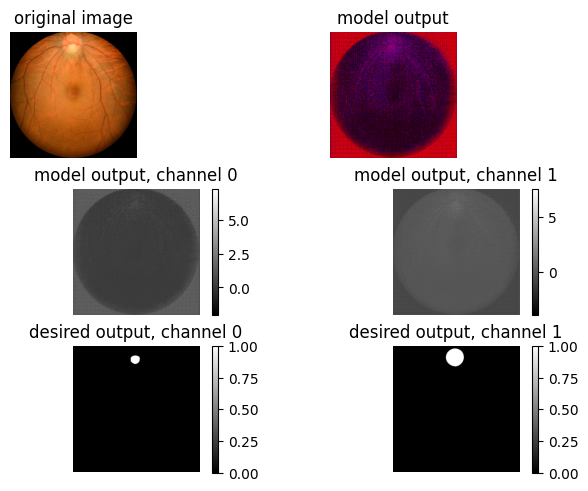

average dice score channel 0: 0.007755, channel 1: 0.030272


In [10]:
sum_score = [0, 0]
for j, batch in enumerate(train_dataloader):
    new_images = model(batch[0])
    if j == 0:
        plot_model_output((batch[0], new_images[0].detach(), batch[1]))
    np.sum(np.array(metric(new_images, batch[1])), axis=0)
    sum_score = [sum_score[i] + np.sum(np.array(metric(new_images, batch[1])), axis=0)[i] for i in range(len(sum_score))]
average_score = [score/number_of_images for score in sum_score]
print("average dice score channel 0: %f, channel 1: %f" % (average_score[0], average_score[1]))